In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, inspect, sys

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
import eli5
from eli5.sklearn import PermutationImportance

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_3 as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib_3' from '/home/marie-anne/code/Oct20_EPRI/Task3/NB/epri_mc_lib_3.py'>

In [50]:
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data_survival_2.csv'),)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Observed              1000 non-null   bool   
 1   F_Time                1000 non-null   float64
 2   NDE_cycle             1000 non-null   int64  
 3   diff_two_peaks_ratio  1000 non-null   float64
 4   amp_ratio             1000 non-null   float64
 5   pos_ratio             1000 non-null   float64
 6   energy_ratio          1000 non-null   float64
 7   NLE_ratio_51_17       1000 non-null   float64
 8   NLE_ratio_85_17       1000 non-null   float64
 9   NLE_ratio_51_119      1000 non-null   float64
 10  NLO_avg               1000 non-null   float64
 11  Avg_RP                1000 non-null   float64
 12  ACEE_30_Avg_58        1000 non-null   float64
 13  ACEE_500_Avg_58       1000 non-null   float64
 14  ACPD_Avg_58           1000 non-null   float64
dtypes: bool(1), float64(13

In [52]:
data_x = data.iloc[:, 2:]
data_y = data.iloc[:, 0:2]

In [53]:
data_y

,Observed,F_Time
0,True,3.650498e+05
1,True,1.146995e+06
2,True,6.493515e+05
3,True,9.246254e+05
4,True,5.521059e+05
...,...,...
995,True,4.542517e+05
996,True,2.449483e+05
997,False,1.953314e+06
998,False,5.054954e+05


## Train test split

In [54]:
X_train, X_test, y_train_pre, y_test_pre = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42)

In [55]:
y_train = y_train_pre.to_records(index=False)
y_test = y_test_pre.to_records(index=False)

# Accelerated Time Failure models

The concordance index is defined as the proportion of all comparable pairs in which the predictions and outcomes are concordant.

We chose to run the GB with e'ipcwls' ( The loss ‘ipcwls’ refers to inverse-probability of censoring weighted least squares error.) as with this method we can return *time to event* and not only log hazard ratio and they adjust for censoring.

## Gradient boosting with regression trees

First we tested on a single split or 'stump' and print the resulting concordance index.

In [115]:
concordance_index_ipcw(y_train, y_test, X_test)

ValueError: Expected 1D array, got 2D array instead:
array=[[ 3.00000000e+05  7.30615146e-01  1.09667201e+00 ... -1.01105733e+00
  -1.49823273e+00  4.71438388e+00]
 [ 0.00000000e+00  7.74746168e-01  9.74372285e-01 ... -4.84877927e-01
  -3.26719913e+00  3.83265364e+00]
 [ 7.50000000e+05  3.85559486e-01  1.11738882e+00 ... -8.96272039e-01
  -1.48092735e+00  3.75658117e+00]
 ...
 [ 3.00000000e+05  5.34826736e-01  1.15161641e+00 ... -9.70281613e-01
  -1.55110472e+00  4.46566010e+00]
 [ 7.50000000e+05  2.72068862e-01  7.97394788e-01 ... -9.88335798e-01
  -1.39797319e+00  2.87397703e+00]
 [ 9.00000000e+05  3.49613670e-01  1.15381165e+00 ... -1.08159019e+00
  -1.56916489e+00  2.94186114e+00]].


In [56]:
stump = GradientBoostingSurvivalAnalysis(loss='ipcwls',
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42
)
stump.fit(X_train, y_train)
cindex = stump.score(X_test, y_test)

print(round(cindex, 3))
mc.score_survival_model(stump, X_test, y_test)

0.883


0.8825459884273253

### Gridsearch CV

In [112]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators': [250, 500, 750, 1000, 1250],
              'max_depth': [2, 3, 4],
              'min_impurity_decrease': [0, 0.01],
              'subsample': [0.4, 0.5, 0.6]
             }
cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=0) #to use first to refine search
GSCV_tree = GridSearchCV(GradientBoostingSurvivalAnalysis(loss='ipcwls', random_state=42), param_grid, 
                         scoring=mc.score_survival_model,
                   n_jobs=4, refit=False,
                   cv=cv, verbose=1)

In [113]:
GSCV_tree.fit(X_train, y_train)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  7.8min


KeyboardInterrupt: 

In [59]:
GSCV_tree.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'min_impurity_decrease': 0,
 'n_estimators': 1000,
 'subsample': 0.5}

### Model performance

In [66]:
GB_tree = GradientBoostingSurvivalAnalysis(
    loss='ipcwls',
    subsample=0.5,
    min_impurity_decrease=0,
    learning_rate=0.01, 
    max_depth=3, 
    random_state=42
)

Testing several n_estimators

In [110]:
# scores_GB_tree.items()
scores =  pd.DataFrame()
for n_estimators in range(1, 3000, 100):
    GB_tree.set_params(n_estimators=n_estimators)
    GB_tree.fit(X_train, y_train)
    results = pd.DataFrame({'n_estimators': n_estimators,
                           'ci_train': GB_tree.score(X_train, y_train),
                            'ci_test': GB_tree.score(X_test, y_test)
                           }, index=[0])
    scores = scores.append(results, ignore_index=True)
    

#     scores_GB_tree_train[n_estimators] = GB_tree.score(X_train, y_train)
#     scores_GB_tree_test[n_estimators] = GB_tree.score(X_test, y_test)
    #feat_imp[n_estimators] = GB_tree.feature_importances_ 

Plotting vs n_estimators

Text(0.5, 1.0, 'Gradient boosting with regression trees')

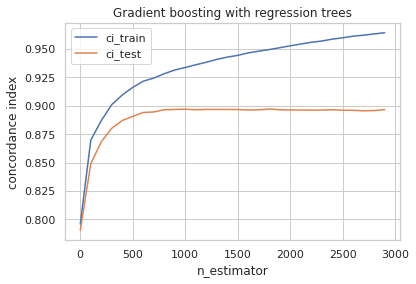

In [111]:
sns.set(style='whitegrid')
scores.set_index('n_estimators').plot()
plt.xlabel('n_estimator')
plt.ylabel('concordance index')
plt.title('Gradient boosting with regression trees')

## Gradient boosting with component-wise least squares

### Gridsearch CV

In [68]:
param_grid = {'learning_rate': [0.01, 0.1, 0.5, 1],
              'n_estimators': [50, 100, 500, 1000, 2000, 3000],
              'subsample': [0, 0.05, 0.2, 0.5, 1],
              'dropout_rate': [0, 0.05]
             }
cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=0)
GSCV_IPCWLS = GridSearchCV(ComponentwiseGradientBoostingSurvivalAnalysis(loss='ipcwls', random_state=42), param_grid, scoring=mc.score_survival_model,
                   n_jobs=4, refit=False,
                   cv=cv, verbose=1)

In [69]:
GSCV_IPCWLS.fit(X_train, y_train)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 260 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 518 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 908 tasks      | elapsed:  8.4min
[Parallel(n_jobs=4)]: Done 1430 tasks      | elapsed: 14.5min


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [63]:
round(GSCV_IPCWLS.best_score_, 3), GSCV_IPCWLS.best_params_

(0.861, {'learning_rate': 1, 'n_estimators': 3000, 'subsample': 1})

### Model performance

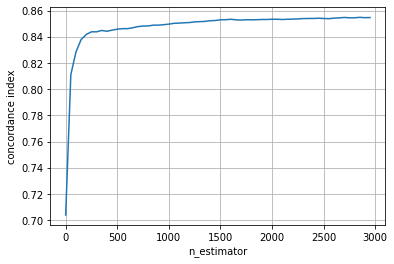

In [64]:
scores_GB_CWLS = {}

GB_CWLS = ComponentwiseGradientBoostingSurvivalAnalysis(
    loss='ipcwls', learning_rate=1.0, random_state=42)

for n_estimators in range(1, 3000, 100):
    GB_CWLS.set_params(n_estimators=n_estimators)
    GB_CWLS.fit(X_train, y_train)
    scores_GB_CWLS[n_estimators] = GB_CWLS.score(X_test, y_test)

x, y = zip(*scores_GB_CWLS.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [65]:
GB_CWLS.predict(X_test)

array([1198300.87661695, 2433163.29574784, 1200968.1565857 ,
       2544865.02910601,  577674.73153392, 1320834.67743152,
       1457471.92145452, 1958363.16063422, 1844077.66421392,
        918476.36686895,  748362.95575877,  873943.13433652,
        436088.09880346,  993652.7593529 , 2767139.47761128,
        861613.95168809,  306990.99592096, 1056942.70016581,
       1174755.69578226, 1060057.5814499 ,  617286.90634377,
        707408.6372699 ,  551893.50255912, 2397447.66601511,
        501821.44415194, 1429887.42859959,  474842.44331725,
       4428279.32743935, 4420067.42019203, 1333692.10770931,
        413391.79576477, 1157440.61057475, 1205004.42449409,
       2606236.95302387,  668543.02276655,  853622.25648092,
       1488361.04117517,  611987.54895236,  451935.17509382,
       2424732.50177592,  591111.8256123 ,  643114.64144072,
       2058085.3471405 , 1440084.58140353,  810576.13916939,
       2714743.98219785, 1669685.67623614, 1335951.50209145,
        720107.36110554,

### Coeffficients

In [93]:
coef = pd.Series(GB_CWLS.coef_, ["Intercept"] + X_train.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

Number of non-zero coefficients: 10


NLE_ratio_85_17         4.383179
amp_ratio               4.147651
energy_ratio           -3.711160
ACPD_Avg_58            -1.477117
diff_two_peaks_ratio   -0.632922
ACEE_500_Avg_58        -0.614446
NLO_avg                -0.195356
ACEE_30_Avg_58          0.064791
Avg_RP                 -0.000653
NDE_cycle              -0.000002
dtype: float64

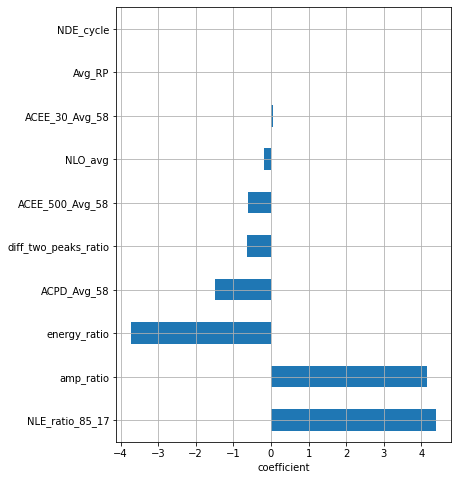

In [94]:
_, ax = plt.subplots(figsize=(6, 8))
coef_nz.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

## Permutation Feature importance

In [30]:
perm = PermutationImportance(GB_AFT, n_iter=15)
perm.fit(X_test, y_test)

PermutationImportance(estimator=ComponentwiseGradientBoostingSurvivalAnalysis(learning_rate=1.0,
                                                                              loss='ipcwls',
                                                                              n_estimators=300,
                                                                              random_state=0),
                      n_iter=15)

In [31]:
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    "no regularization": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, max_depth=1, random_state=0
    ),
    "learning rate": GradientBoostingSurvivalAnalysis(
        learning_rate=0.1, max_depth=1, random_state=0
    ),
    "dropout": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0
    ),
    "subsample": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0
    ),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        scores_reg[name].append(cindex)

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)



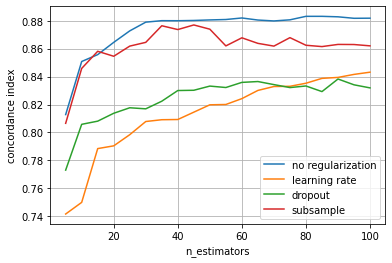

In [32]:
ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)

In [33]:
class EarlyStoppingMonitor:

    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.05, subsample=0.5,
    max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(25, 50)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

Fitted base learners: 620
Performance on test set 0.871


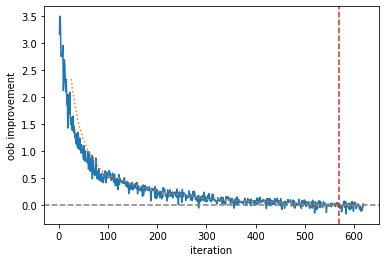

In [34]:
improvement = pd.Series(
    est_early_stopping.oob_improvement_,
    index=np.arange(1, 1 + len(est_early_stopping.oob_improvement_))
)
ax = improvement.plot(xlabel="iteration", ylabel="oob improvement")
ax.axhline(0.0, linestyle="--", color="gray")
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle="--", color="C3")

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=":")

